In [1]:
# Importing pandas library to help with data analyse
import pandas as pd
# Importing numpy library
import numpy as np
# Importing pyplot libary for plotting graphs
import matplotlib.pyplot as plt
# Importing LabelEncoder 
from sklearn.preprocessing import LabelEncoder
# Importing accuracy_score
from sklearn.metrics import accuracy_score
# Importing MLPClassifier 
from sklearn.neural_network import MLPClassifier
# Importing mode 
from scipy.stats import mode
# Importing Counter 
from collections import Counter
#Importing warning messages
import warnings
#Importing exceptions from warning messages
from sklearn.exceptions import ConvergenceWarning
#Importing exceptions from warning messages
from scipy import stats

In [2]:
# Suppress FutureWarnings 
warnings.filterwarnings("ignore", message="Unlike other reduction functions")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# Load training data from file
trainData = pd.read_csv('Training.csv')
# Load testing data from file
testData = pd.read_csv('Testing.csv')

In [4]:
# Initializing label encoder
labelEncoder = LabelEncoder()
# Transform and encode labels for training
trainData['prognosis'] = labelEncoder.fit_transform(trainData['prognosis'])
# Transform and encode labels for testing
testData['prognosis'] = labelEncoder.transform(testData['prognosis'])

In [5]:
# Dropping the label column from training data
xTrain = trainData.drop('prognosis', axis=1).values
# Getting training labels from data
yTrain = trainData['prognosis'].values
# Getting testing features from data
xTest = testData.drop('prognosis', axis=1).values
# Extract testing labels from data
yTest = testData['prognosis'].values


In [6]:
# Function to calculate Euclidean distance
def euclideanDistance(x1, x2):
    # Calculate Euclidean distance
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [7]:
# K-Nearest Neighbors algorithm function
def KNearest(XTrain, xTrain, XTest, k):
    # empty list for prediction storing
    predictions = []
    # Loop through every test sample
    for x in XTest:
        # Calculating distance from the current test sample to all training samples
        distances = [euclideanDistance(x, xTrain) for xTrain in XTrain]
        # Finds the K smallest distances
        kIndices = np.argsort(distances)[:k]
        # Getting labels of the k-nearest neighbors
        kNearestLabels = [xTrain[i] for i in kIndices]
        # calculateing the most common label
        mostCommon = mode(kNearestLabels)[0][0]
        # Append the prediction
        predictions.append(mostCommon)
    # Output prediction list
    return predictions


In [8]:
# Naive Bayes classifier class/function
class NaiveBayes:
    def __init__(self, varSmoothing=1e-9):
        # Variance smoothing configuration
        self.varSmoothing = varSmoothing

    def fit(self, X, y):
        # Identify all unique classes
        self.classes = np.unique(y)
        # Initializing the means
        self.mean = np.zeros((len(self.classes), X.shape[1]), dtype=np.float64)
        # Initializing the variances
        self.var = np.zeros((len(self.classes), X.shape[1]), dtype=np.float64)
        # Initializing the priors
        self.priors = np.zeros(len(self.classes), dtype=np.float64)
        # Looping through every class
        for idx, c in enumerate(self.classes):
            # Getting the samples belonging to class c
            X_c = X[y == c]
            # Calculating the mean
            self.mean[idx] = X_c.mean(axis=0)
            # Calculating the variance and apply smoothing
            self.var[idx] = X_c.var(axis=0) + self.varSmoothing
            # Calculating the prior probability
            self.priors[idx] = X_c.shape[0] / float(len(y))

    def predict(self, X):
        # Predicting sample lables
        yPred = [self._predict(x) for x in X]
        return np.array(yPred)

    def _predict(self, x):
        # Storing each class posterior probabilities
        posteriors = []
        # Each class gets looped through
        for idx, c in enumerate(self.classes):
            # Storing prior probability
            prior = np.log(self.priors[idx])
            # Calculating log probabilities
            classConditional = np.sum(np.log(self._pdf(idx, x)))
            # Calculating posterior probability
            posterior = prior + classConditional
            posteriors.append(posterior)
        # Outputs the highest posterior probability class
        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        # Calculating the mean of the class
        mean = self.mean[class_idx]
        # Storing the variance of the class
        var = self.var[class_idx]
        # Calculating numerator of the Gaussian probability density function
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        # Calculating denominator
        denominator = np.sqrt(2 * np.pi * var)
        # Outputing probability density function
        return numerator / denominator

In [9]:
# Decision Tree class/function
class DecisionTree:
    def __init__(self, maxDepth=3):
        # Setting tree deph
        self.maxDepth = maxDepth

    class Node:
        def __init__(self, featureIndex=None, threshold=None, left=None, right=None, *, value=None):
            # Indexing features used for splitting
            self.featureIndex = featureIndex
            # Setting the threshold value for splitting
            self.threshold = threshold
            # The left child node
            self.left = left
            # The right child node
            self.right = right
            # Node value
            self.value = value

    def fit(self, X, y):
        # Start of tree growth
        self.tree = self.growTree(X, y)

    def growTree(self, X, y, depth=0):
        # Sets the number of samples and features
        numSamples, numFeatures = X.shape
        # Sets the number of unique labels
        numLabels = len(np.unique(y))

        # Checking for stopping criteria
        if (depth >= self.maxDepth or numLabels == 1):
            # Calculating most common label
            leafValue = self.mostCommonLabel(y)
            # Outputs the leaf node
            return self.Node(value=leafValue)

        # Calculating best feature and threshold for splitting
        bestFeat, bestThresh = self.bestCriteria(X, y, numSamples, numFeatures)

        # Dividing dataset then growing left and right children
        leftIDXS, rightIDXS = self.split(X[:, bestFeat], bestThresh)
        left = self.growTree(X[leftIDXS, :], y[leftIDXS], depth + 1)
        right = self.growTree(X[rightIDXS, :], y[rightIDXS], depth + 1)
        return self.Node(bestFeat, bestThresh, left, right)

    def bestCriteria(self, X, y, numSamples, numFeatures):
        # Initializing the best Gini index as infinity
        bestGini = np.inf
        # Initializing the best feature index and threshold as None
        bestIDX, bestThresh = None, None
        # Looping through all features
        for feat_idx in range(numFeatures):
            # Sorting values and corresponding classes
            thresholds, classes = zip(*sorted(zip(X[:, feat_idx], y)))
            # Initializing number of samples in the left split
            numLeft = 0
            # Initializing number of samples in the right split
            numRight = numSamples
            # Left split counter
            leftCounts = Counter()
            # Right split counter
            rightCounts = Counter(classes)
            # Looping through the sorted samples
            for i in range(1, numSamples):
                # Creating class of the previous sample
                c = classes[i - 1]
                # Increasing count for the class in the left split
                leftCounts[c] += 1
                # Decreacing count for the class in the right split
                rightCounts[c] -= 1
                # Increasing the samples number in the left split
                numLeft += 1
                # Decreasing the samples number in the right split
                numRight -= 1
                # Checking if the current and previous samples have different classes
                if thresholds[i] == thresholds[i - 1]:
                    continue
                # Calculating the Gini index for the current split
                giniLeft = 1.0 - sum((n / numLeft) ** 2 for n in leftCounts.values())
                giniRight = 1.0 - sum((n / numRight) ** 2 for n in rightCounts.values())
                gini = (numLeft * giniLeft + numRight * giniRight) / numSamples
                # Updating best split if the current Gini index is lower than the best
                if gini < bestGini:
                    bestGini = gini
                    bestIDX = feat_idx
                    bestThresh = (thresholds[i] + thresholds[i - 1]) / 2
        # Outputting best feature index and threshold for splitting
        return bestIDX, bestThresh

    def split(self, XColumn, splitThresh):
        # Number of samples that go to the left child
        leftIDXS = np.argwhere(XColumn <= splitThresh).flatten()
        # Number of samples that go to the right child
        rightIDXS = np.argwhere(XColumn > splitThresh).flatten()
        return leftIDXS, rightIDXS

    def mostCommonLabel(self, y):
        # Outputing most common label in the dataset
        return mode(y)[0][0]

    def predict(self, X):
        # Predicting the label for each sample
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _predict(self, inputs, node):
        # Checking that the current node is a leaf node
        if node.value is not None:
            # Outputting the value of the leaf node
            return node.value
        # Checking whether to go left or right based on the feature value and threshold
        if inputs[node.featureIndex] <= node.threshold:
            # Outputting to the left child
            return self._predict(inputs, node.left)
        else:
            # Outputting to the right child
            return self._predict(inputs, node.right)


In [10]:
# MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(2,), max_iter=40, activation='relu', solver='adam', random_state=1)


In [11]:
# Stored models dictionary
models = {
    'Naive Bayes': NaiveBayes(varSmoothing=1e-9),
    'K-Nearest Neighbors': lambda XTrain, xTrain, XTest: KNearest(XTrain, xTrain, XTest, 2),
    'Decision Tree': DecisionTree(maxDepth=20),
    'Simple MLP': mlp
}

In [12]:
# Accuracy score dictionary
accuracyScores = {}
for name, model in models.items():
    if name == 'K-Nearest Neighbors':
        # Geting the predictions using KNearest Neighbors
        yPred = model(xTrain, yTrain, xTest)
    else:
        # Training model
        model.fit(xTrain, yTrain)
        # Getting the predictions
        yPred = model.predict(xTest)
    # Calculating the accuracy
    accuracy = accuracy_score(yTest, yPred)
    # Storing the accuracy in the dictionary
    accuracyScores[name] = accuracy
    print(f"{name} Accuracy: {accuracy}")


C:\Users\ojdonnelly\AppData\Local\Temp\ipykernel_19296\564066109.py:40: RuntimeWarning: divide by zero encountered in log
  classConditional = np.sum(np.log(self._pdf(idx, x)))


Naive Bayes Accuracy: 0.9761904761904762
K-Nearest Neighbors Accuracy: 1.0
Decision Tree Accuracy: 0.5476190476190477
Simple MLP Accuracy: 0.14285714285714285


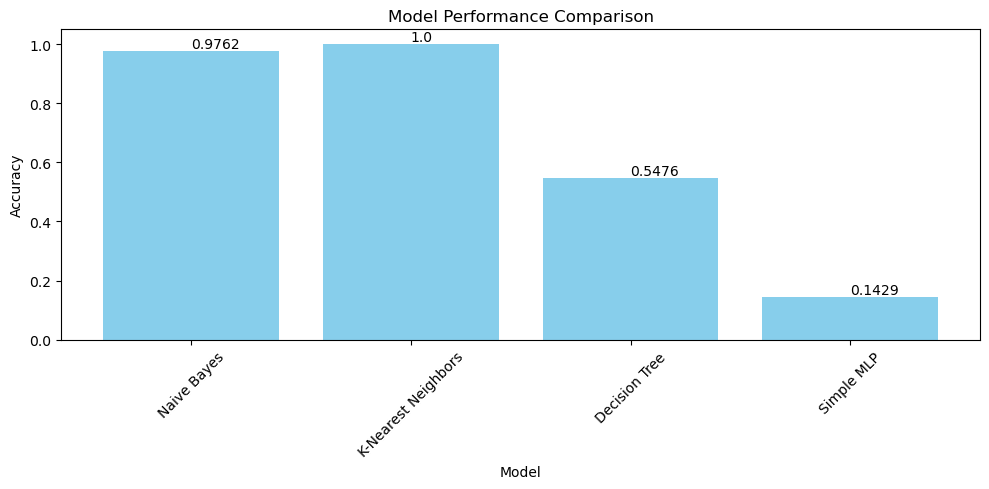

In [15]:
# Plotting the model accuracies
plt.figure(figsize=(10, 5))
# Creating a bar chart
bars = plt.bar(accuracyScores.keys(), accuracyScores.values(), color='skyblue')
for bar in bars:
    yval = bar.get_height()
    # Displaying accuracy at the top of each bar
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')
# Labelling the x-axis
plt.xlabel('Model')
# Labelling the y-axis
plt.ylabel('Accuracy')
# Setting title of the chart
plt.title('Model Performance Comparison')
# Rotateing the x-axis labels 
plt.xticks(rotation=45)
# Setting y-axis limits
plt.ylim(0, 1.05)
# Adjusting layout 
plt.tight_layout()
# Displaying graph
plt.show()